In [1]:
#Random Forest Model
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Download stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dilki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Predefined list of network-specific stopwords
network_stopwords = set([
    'seq', 'win', 'len', 'ack', 'udp', 'tcp', 'flags', 'ttl', 'id', 'offset', 'tos', 'length', 
    'info', 'dst', 'src', 'protocol', 'version', 'ihl', 'checksum', 'options', 'urg', 'psh', 
    'rst', 'syn', 'fin', 'payload', 'data', 'options', 'mac', 'ethernet', 'frame', 'srcport', 
    'dstport', 'tcpflags', 'ttl', 'id', 'offset', 'tos', 'flags', 'time', 'sport', 'dport'
])

In [3]:
# Including standard stopwords as well
stopwords = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 
    'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 
    'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 
    'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 
    'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 
    'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 
    'should', 'now'
]).union(network_stopwords)

In [4]:
# Including standard stopwords as well
all_stopwords = set(nltk_stopwords.words('english')).union(network_stopwords)


In [5]:
# Importing the dataset
dataset = pd.read_csv('dataset - Copy (2).tsv', delimiter='\t', quoting=3)

In [6]:
# Adding a small amount of noise to the dataset to avoid overfitting
np.random.seed(0)
noise = np.random.binomial(1, 0.05, size=dataset.shape[0])
dataset['Label'] = dataset.iloc[:, 1] ^ noise

In [7]:
# Sample a smaller subset of the dataset for more realistic results
dataset = dataset.sample(n=500, random_state=0).reset_index(drop=True)

In [8]:
# Initialize an empty list to store the logs
corpus = []
ps = PorterStemmer()

# Loop through each row in the dataset
for i in range(len(dataset)):
    info = dataset['Info'][i]
    
    # Convert non-string values to strings and handle NaNs
    if pd.isnull(info):
        info = ''
    else:
        info = str(info)
    
    # Clean the log
    log = re.sub('[^a-zA-Z0-9]', ' ', info)
    log = log.lower()
    log = log.split()
    
    # Remove stopwords and apply stemming
    log = [ps.stem(word) for word in log if word not in stopwords]
    
    # Join the words back into a single string
    log = ' '.join(log)
    
    # Append the cleaned log to the corpus
    corpus.append(log)


In [9]:
# Creating the CountVectorizer model with enhanced parameters
cv = CountVectorizer(max_features=3000, ngram_range=(1, 2))
X = cv.fit_transform(corpus).toarray()
y = dataset['Label'].values

In [10]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

In [11]:
# Training the original Random Forest classifier
rf_classifier_original = RandomForestClassifier(random_state=0)
rf_classifier_original.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [12]:
#Predicting the Test set results with the original Random Forest classifier
rf_y_pred_original = rf_classifier_original.predict(X_test)

In [13]:
# Evaluating the original Random Forest classifier
rf_accuracy_original = accuracy_score(y_test, rf_y_pred_original)
rf_precision_original = precision_score(y_test, rf_y_pred_original)
rf_recall_original = recall_score(y_test, rf_y_pred_original)
rf_f1_original = f1_score(y_test, rf_y_pred_original)
rf_cm_original = confusion_matrix(y_test, rf_y_pred_original)

# Displaying the results for the original Random Forest classifier
print("Original Random Forest Classifier")
print(f"Accuracy: {rf_accuracy_original:.4f}")
print(f"Precision: {rf_precision_original:.4f}")
print(f"Recall: {rf_recall_original:.4f}")
print(f"F1 Score: {rf_f1_original:.4f}")

Original Random Forest Classifier
Accuracy: 0.9400
Precision: 0.9467
Recall: 0.9726
F1 Score: 0.9595


In [14]:
# Defining a parameter grid for hyperparameter tuning using RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

In [15]:
# Performing RandomizedSearchCV to find the best hyperparameters
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=0), param_distributions=param_grid, n_iter=200, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=RandomForestClassifier(random_state=0), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [None, 10, 20, 30, 40, 50,
                                                      60, 70, 80, 90, 100],
                                        'min_samples_leaf': [1, 2, 4, 8, 16],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [100, 200, 300, 500,
                                                         1000]},
                   scoring='accuracy')

In [16]:
# Extracting the best parameters
best_params = random_search.best_params_

In [17]:
# Training the optimized Random Forest model with the best hyperparameters on the full training set
rf_classifier_optimized = RandomForestClassifier(**best_params, random_state=0)
rf_classifier_optimized.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, n_estimators=200, random_state=0)

In [18]:
# Predicting probabilities for the Test set results with the optimized Random Forest classifier
rf_y_prob_optimized = rf_classifier_optimized.predict_proba(X_test)[:, 1]

In [19]:
# Adjusting the threshold for classification
optimal_threshold = 0.5  # Default threshold
rf_y_pred_optimized = (rf_y_prob_optimized >= optimal_threshold).astype(int)

In [20]:
# Evaluating the optimized Random Forest classifier with adjusted threshold
rf_accuracy_optimized = accuracy_score(y_test, rf_y_pred_optimized)
rf_precision_optimized = precision_score(y_test, rf_y_pred_optimized)
rf_recall_optimized = recall_score(y_test, rf_y_pred_optimized)
rf_f1_optimized = f1_score(y_test, rf_y_pred_optimized)
rf_cm_optimized = confusion_matrix(y_test, rf_y_pred_optimized)

# Displaying the results for the optimized Random Forest classifier
print("\nOptimized Random Forest Classifier with Adjusted Threshold")
print(f"Best Parameters: {best_params}")
print(f"Accuracy: {rf_accuracy_optimized:.4f}")
print(f"Precision: {rf_precision_optimized:.4f}")
print(f"Recall: {rf_recall_optimized:.4f}")
print(f"F1 Score: {rf_f1_optimized:.4f}")


Optimized Random Forest Classifier with Adjusted Threshold
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': True}
Accuracy: 0.9500
Precision: 0.9595
Recall: 0.9726
F1 Score: 0.9660


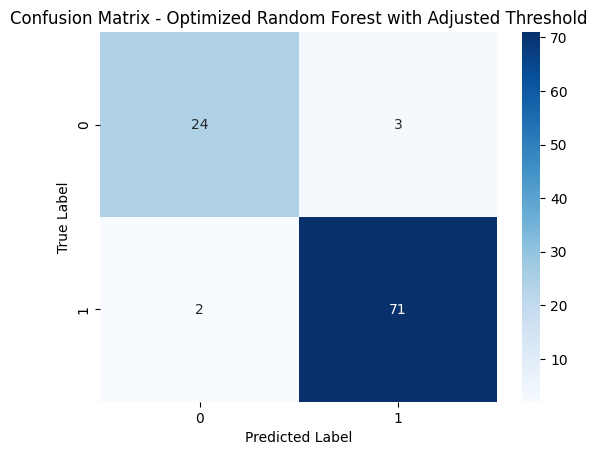

In [21]:
# Visualizing the confusion matrix of the optimized Random Forest classifier as a heatmap
sns.heatmap(rf_cm_optimized, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - Optimized Random Forest with Adjusted Threshold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [22]:
# Dumping the trained optimized Random Forest model to a file
#joblib.dump(rf_classifier_optimized, 'rf_model_optimized.joblib')

In [23]:
# Dumping the CountVectorizer
#joblib.dump(cv, 'count_vectorizer.joblib')


Data Visualization

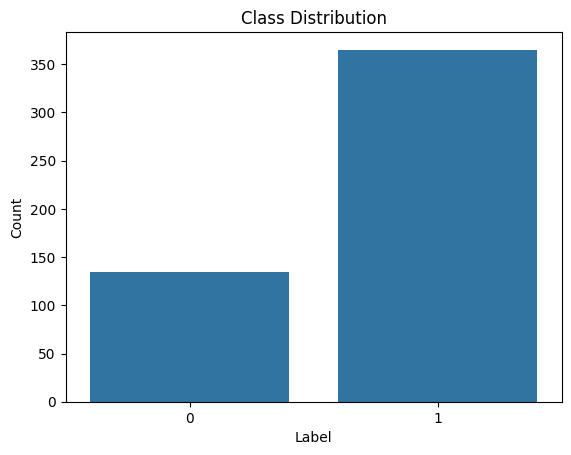

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the class distribution
sns.countplot(x='Label', data=dataset)
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


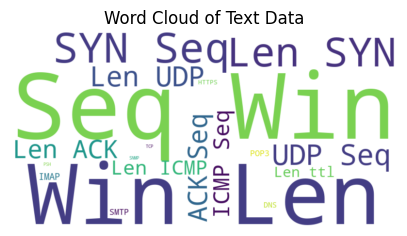

In [25]:
#Word Cloud for Text Data
from wordcloud import WordCloud

# Combine all text data
text_data = ' '.join(dataset['Info'].astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the word cloud
plt.figure(figsize=(5, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Data')
plt.show()


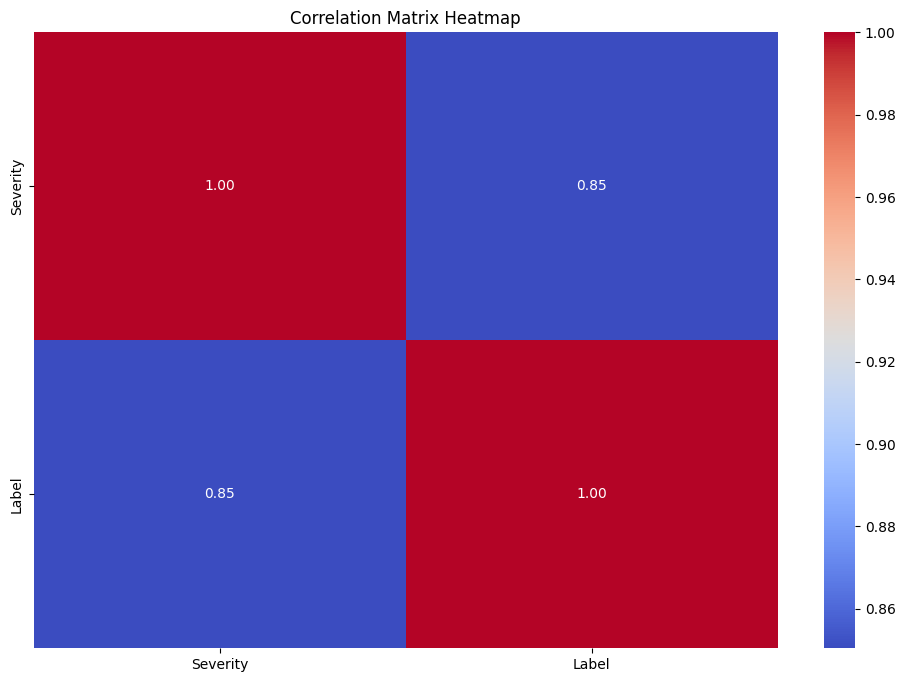

In [26]:
# Select only the numeric columns
numeric_columns = dataset.select_dtypes(include=[np.number]).columns

# Calculate correlation matrix for numeric columns
correlation_matrix = dataset[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()


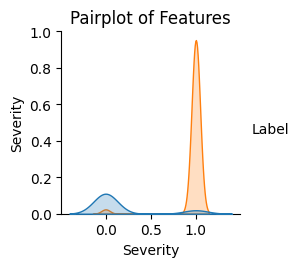

In [27]:
#Pairplot for Feature Relationships
# Visualize relationships between features
sns.pairplot(dataset, hue='Label')
plt.title('Pairplot of Features')
plt.show()


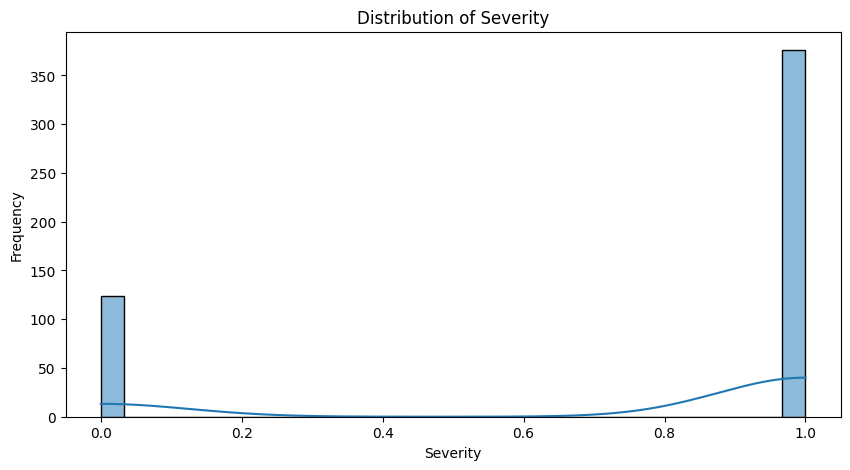

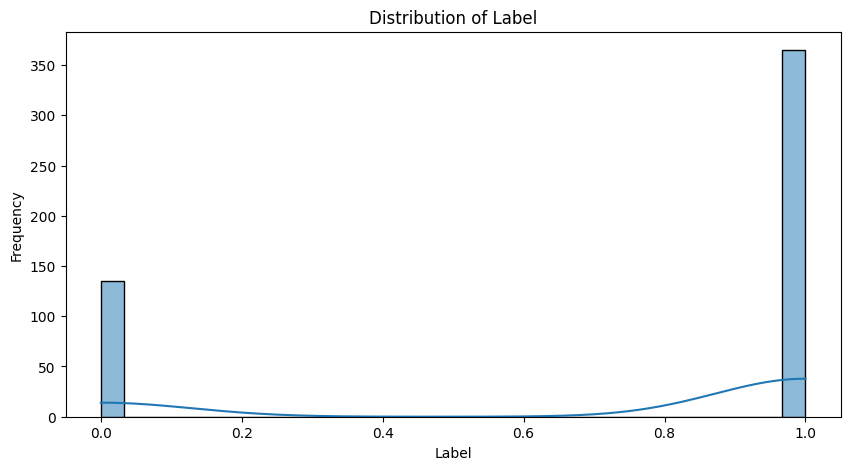

In [28]:
# Plot distributions of numerical features
numerical_features = dataset.select_dtypes(include=['int64', 'float64']).columns

for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(dataset[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


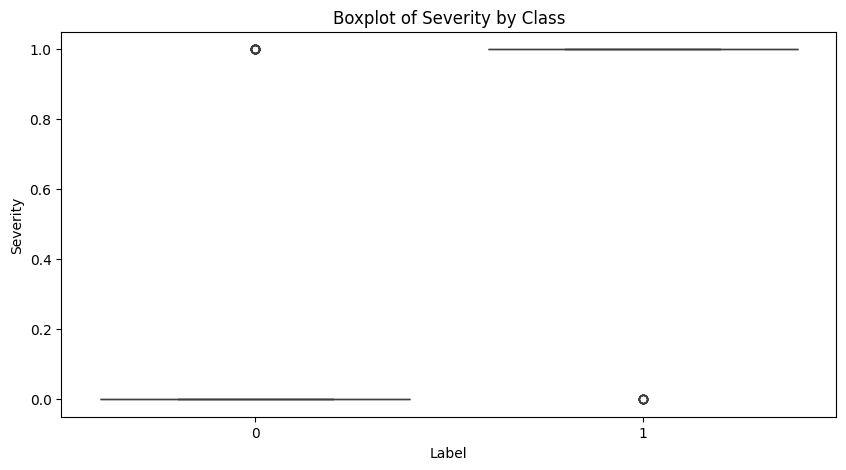

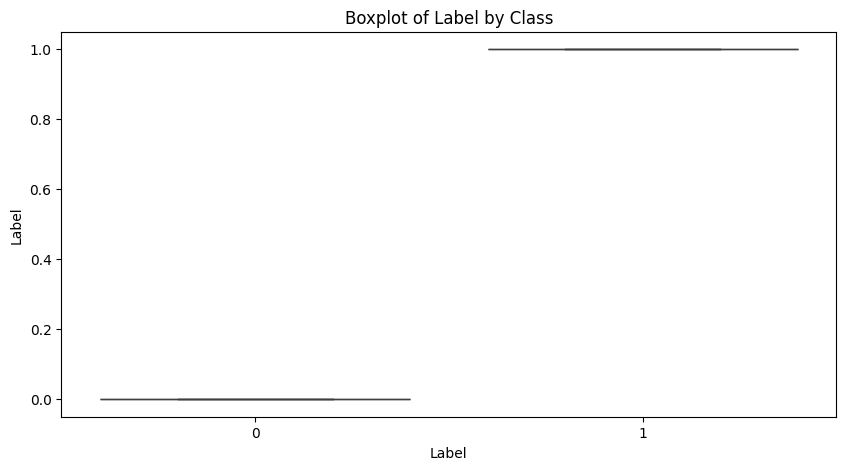

In [29]:
# Plot boxplots for numerical features by class
for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Label', y=feature, data=dataset)
    plt.title(f'Boxplot of {feature} by Class')
    plt.xlabel('Label')
    plt.ylabel(feature)
    plt.show()
